In [4]:
import pandas as pd
import sys
import matplotlib.pyplot as plt
import optuna
from lightgbm import LGBMClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import (
    classification_report,
    accuracy_score,
    confusion_matrix,
    roc_auc_score,
    ConfusionMatrixDisplay
)
sys.path.append('./src')
import engineer_features as ef

In [5]:
data = pd.read_csv('Fraudulent_E-Commerce_Transaction_Data_2.csv')

In [6]:
X_train, X_test, y_train, y_test = ef.engineer_features(data, use_linear_model=False, use_smote=False)
print(f"Training features shape: {X_train.shape}")
print(f"Test features shape: {X_test.shape}")

Strategy: Using ORIGINAL amount. Dropping 'log_transaction_amount'.
Feature engineering complete.
Skipping SMOTE. Returning standard train/test split.
Training features shape: (18907, 24)
Test features shape: (4727, 24)


c:\Users\lesli\Documents\GitHub\BT4012-Group-15-Ecommerce-Fraud\src\engineer_features.py:99: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['customer_avg_spend_before_tx'].fillna(0, inplace=True)


In [7]:
def objective(trial):
    # Define parameters to tune
    params = {
        'objective': 'binary',
        'metric': 'auc',
        'verbosity': -1,
        'device': 'gpu',
        'n_estimators': trial.suggest_int('n_estimators', 100, 1000),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.2, log=True),
        'num_leaves': trial.suggest_int('num_leaves', 20, 50),
        'max_depth': trial.suggest_int('max_depth', 5, 20),
        'min_child_samples': trial.suggest_int('min_child_samples', 20, 100),
        'subsample': trial.suggest_float('subsample', 0.6, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
        'reg_alpha': trial.suggest_float('reg_alpha', 1e-3, 10.0, log=True),
        'reg_lambda': trial.suggest_float('reg_lambda', 1e-3, 10.0, log=True),
        'class_weight': 'balanced'
    }
    
    model = LGBMClassifier(**params, random_state=ef.RANDOM_SEED)
    score = cross_val_score(model, X_train, y_train, cv=3, scoring='roc_auc', n_jobs=-1)
    
    return score.mean()

In [8]:
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100)

print(f"Best ROC-AUC (from CV): {study.best_value:.4f}")
print("Best Parameters:")
print(study.best_params)

best_lgbm_model = LGBMClassifier(
    **study.best_params,
    objective='binary',
    metric='auc',
    verbosity=-1,
    device='gpu',
    class_weight='balanced',
    random_state=ef.RANDOM_SEED
)

best_lgbm_model.fit(X_train, y_train)

[I 2025-11-16 17:12:46,610] A new study created in memory with name: no-name-661f950c-ee8a-49ff-a41f-0794217cad58
[I 2025-11-16 17:13:07,887] Trial 0 finished with value: 0.7515900488157747 and parameters: {'n_estimators': 724, 'learning_rate': 0.028206376513149105, 'num_leaves': 31, 'max_depth': 12, 'min_child_samples': 61, 'subsample': 0.6803813597658761, 'colsample_bytree': 0.9408680718538891, 'reg_alpha': 7.509675308485523, 'reg_lambda': 0.0018953897184569113}. Best is trial 0 with value: 0.7515900488157747.
[I 2025-11-16 17:13:36,144] Trial 1 finished with value: 0.7185983928854306 and parameters: {'n_estimators': 877, 'learning_rate': 0.10843593686412813, 'num_leaves': 50, 'max_depth': 19, 'min_child_samples': 86, 'subsample': 0.9386038406595513, 'colsample_bytree': 0.9302556589233482, 'reg_alpha': 0.003261780188824836, 'reg_lambda': 0.4043942040485088}. Best is trial 0 with value: 0.7515900488157747.
[I 2025-11-16 17:13:43,931] Trial 2 finished with value: 0.764964508718665 and 

Best ROC-AUC (from CV): 0.7705
Best Parameters:
{'n_estimators': 290, 'learning_rate': 0.010001311502914206, 'num_leaves': 35, 'max_depth': 5, 'min_child_samples': 88, 'subsample': 0.8352932283025634, 'colsample_bytree': 0.9966824422154208, 'reg_alpha': 0.005925649794338654, 'reg_lambda': 0.009196477737019215}


,boosting_type,'gbdt'
,num_leaves,35
,max_depth,5
,learning_rate,0.010001311502914206
,n_estimators,290
,subsample_for_bin,200000
,objective,'binary'
,class_weight,'balanced'
,min_split_gain,0.0
,min_child_weight,0.001
,min_child_samples,88


Accuracy (Test Set): 0.8718
ROC-AUC Score (Test Set): 0.7357

Classification Report (Test Set):
               precision    recall  f1-score   support

Not Fraud (0)       0.98      0.89      0.93      4483
    Fraud (1)       0.22      0.59      0.32       244

     accuracy                           0.87      4727
    macro avg       0.60      0.74      0.62      4727
 weighted avg       0.94      0.87      0.90      4727


Confusion Matrix (Test Set):


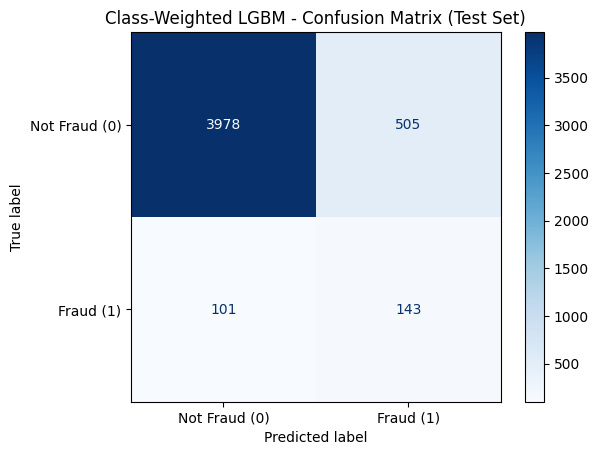

In [9]:
# Evaluation
y_pred = best_lgbm_model.predict(X_test)
y_pred_proba = best_lgbm_model.predict_proba(X_test)[:, 1]

# Metrics
accuracy = accuracy_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred_proba)
print(f"Accuracy (Test Set): {accuracy:.4f}")
print(f"ROC-AUC Score (Test Set): {roc_auc:.4f}")

# Classification Report
print("\nClassification Report (Test Set):")
print(classification_report(y_test, y_pred, target_names=['Not Fraud (0)', 'Fraud (1)']))

# Confusion Matrix
print("\nConfusion Matrix (Test Set):")
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Not Fraud (0)', 'Fraud (1)'])
disp.plot(cmap='Blues')
plt.title("Class-Weighted LGBM - Confusion Matrix (Test Set)")
plt.show()

In [10]:
print("\n--- Top 10 Feature Importances (Tuned Model) ---")
importances = best_lgbm_model.feature_importances_
feature_names = X_train.columns
feature_importance_df = pd.DataFrame({
    'feature': feature_names,
    'importance': importances
}).sort_values(by='importance', ascending=False)

print(feature_importance_df.head(10))


--- Top 10 Feature Importances (Tuned Model) ---
                         feature  importance
0             Transaction Amount        1564
3               Account Age Days         608
11              amount_deviation         584
2                   Customer Age         346
9                Transaction Day         319
7            Transaction Weekday         284
4               Transaction Hour         204
1                       Quantity         182
10             Transaction Month          94
12  Payment Method_bank transfer          65
